In [1]:
# Standard modules
import pickle as pkl
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch_geometric.utils import to_networkx
# NetworkX
import networkx as nx
# RDKit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# Modules from local files
from GNN_mol import GNN
from Dataset import XASDataset
from utils import plot_spectra, plot_learning_curve

/home/a3782/anaconda3/envs/go_gnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Define functions to be used

In [2]:
def train(epoch):
    model.train()
    loss_all = 0
    
    for batch in train_loader:

        batch = batch.to(device)

        optimizer.zero_grad()

        pred = model(batch)
        batch_size = batch.y.shape[0] // 200
        batch.y = batch.y.view(batch_size, 200)

        loss = nn.MSELoss()(pred.double(), batch.y.double())

        loss.backward()

        loss_all += loss.item() * batch.num_graphs
        optimizer.step()

    return loss_all / len(train_loader.dataset)

In [3]:
def test(loader):
    model.eval()
    loss_all = 0

    for batch in loader:
        batch = batch.to(device)

        batch_size = batch.y.shape[0] // 200
        batch.y = batch.y.view(batch_size, 200)

        with torch.no_grad():
            pred = model(batch)

        loss = nn.MSELoss()(pred.double(), batch.y.double())

        loss_all += loss.item() * batch.num_graphs

    return loss_all / len(loader.dataset)

In [4]:
def pred_spec(model, index, test_dataset):
    # Set the model to evaluation mode
    model.eval()

    # Get a single graph from the test dataset
    graph_index = index # Index of the graph you want to predict on
    graph_data = test_dataset[graph_index].to(device)
    batch = Batch.from_data_list([graph_data])

    # Pass the graph through the model
    with torch.no_grad():
        pred = model(batch)

    # Access the predicted output for the single graph
    pred_graph = pred[0]
    true_spectrum = graph_data.y.cpu().numpy()
    predicted_spectrum = pred.cpu().numpy()
    predicted_spectrum = predicted_spectrum.reshape(-1)
    
    return predicted_spectrum, true_spectrum

#### Import dataset

In [5]:
# Path raw directory containing the data
path = "./"
# Load and create the dataset
dataset = XASDataset(path)

Processing...


Total number of molecules 319
Number of atoms in each molecule  [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 26, 25, 26, 26, 24, 24, 24, 24, 25, 24, 25, 24, 24, 26, 25, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 24, 25, 24, 24, 24, 26, 26, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 27, 26, 25, 26, 26, 26, 26, 25, 26, 25, 25, 26, 26, 26, 26, 25, 25, 27, 27, 27, 25, 27, 25, 27, 28, 27, 28, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 25, 28, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 24, 24, 24, 24, 25, 24, 24, 24, 24, 25, 25, 24, 25, 25, 25, 25, 24, 24, 24, 26, 26, 26, 26, 26, 26, 27, 24, 27, 28, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 24, 25, 24, 27, 24, 24, 25, 24, 24, 26, 25, 25, 25, 25, 25, 25, 25,

Done!


In [6]:
# Show detail of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

XASDataset(319)
------------
Number of graphs: 319
Number of features: 10
Number of classes: 63482


In [7]:
# Show details of the first molecule/graph in dataset
data = dataset[0]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[30, 10], edge_index=[2, 76], y=[200], edge_attrs=[76, 4], idx=[1], smiles='[c:0]12[c:4]3[c:8]4[c:10]5[cH:11][cH:14][c:15]6[c:13]4[c:17]4[c:19]([cH:18][cH:16]6)[cH:20][c:22]([OH:25])[c:23]([c:21]14)[CH2:24][CH:1]1[C:2]2([CH:3]=[CH:5][C:6]32[CH:7]([CH:9]5[C:12](=[O:26])[OH:27])[O:29]2)[O:28]1')
------------
Number of nodes: 30
Number of edges: 76
Average node degree: 2.53
Has isolated nodes: False
Has self loops: False
Is undirected: True


#### View data

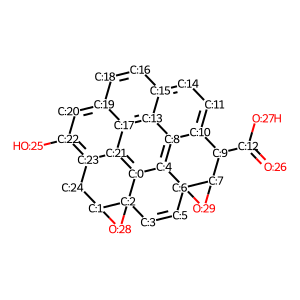

In [8]:
mol = Chem.MolFromSmiles(data.smiles)
mol

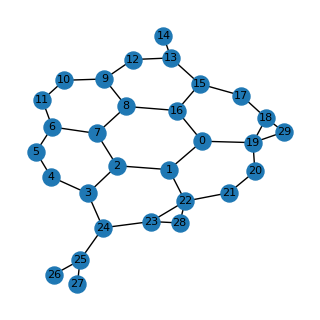

In [9]:
mol_graph = to_networkx(data, to_undirected=True)

plt.figure(figsize=(3,3))

nx.draw(mol_graph, with_labels=True, node_size=150, font_size=8)

plt.show()

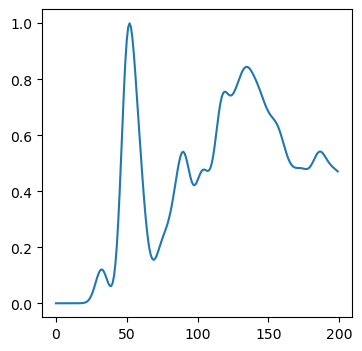

In [10]:
# Show molecule spectrum
plt.figure(figsize=(4,4))

plt.plot(data.y)

plt.show()

#### Split up dataset

In [11]:
train_dataset = dataset[0:252]
val_dataset = dataset[252:280]
test_dataset = dataset[280:]

In [12]:
test_loader = DataLoader(test_dataset, batch_size=30, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=30, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)

In [13]:
print(f'Length of training data loader: {len(train_loader.dataset)}')
print(f'Length of validation data loader: {len(val_loader.dataset)}')
print(f'Length of testing data loader: {len(test_loader.dataset)}')

Length of training data loader: 252
Length of validation data loader: 28
Length of testing data loader: 39


#### Set neural network properties

In [14]:
num_tasks = 200
num_layers = 4
emb_dim = dataset.num_features
in_channels = [int(emb_dim), 100, 200, 300]
out_channels = [100, 200, 300, 300]
gnn_type = "gcn"
heads = int(1)
drop_ratio = 0.8
graph_pooling = "mean"

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
model = model.to(device)
print(model)

GNN(
  (gnn_node): GNN_node(
    (convs): ModuleList(
      (0): GCNConv(10, 100)
      (1): GCNConv(100, 200)
      (2): GCNConv(200, 300)
      (3): GCNConv(300, 300)
    )
    (batch_norms): ModuleList(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_linear): Linear(in_features=300, out_features=200, bias=True)
)


In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=100, min_lr=0.000001)


#### Run neural network training

In [17]:
best_val_error = None
train_losses = []
val_losses = []

for epoch in range(0, 300):

    loss = train(epoch)

    val_error = test(val_loader)
    scheduler.step(val_error)
    # scheduler.step(epoch)
    train_losses.append(loss)
    val_losses.append(val_error)

    current_lr = optimizer.param_groups[0]["lr"]

    if best_val_error is None or val_error <= best_val_error:

        best_val_error = val_error

    if epoch % 25 == 0:
        print(f"Epoch: {epoch:03d}, LR: {current_lr:7f}, TrainLoss: {loss:.7f}, ValLoss:{val_error:7f}, Best_ValLoss:{best_val_error:7f}")

Epoch: 000, LR: 0.010000, TrainLoss: 0.2084591, ValLoss:0.089829, Best_ValLoss:0.089829
Epoch: 025, LR: 0.010000, TrainLoss: 0.0136399, ValLoss:0.014393, Best_ValLoss:0.011320
Epoch: 050, LR: 0.010000, TrainLoss: 0.0103262, ValLoss:0.010648, Best_ValLoss:0.009652
Epoch: 075, LR: 0.010000, TrainLoss: 0.0103070, ValLoss:0.010327, Best_ValLoss:0.009449
Epoch: 100, LR: 0.010000, TrainLoss: 0.0093573, ValLoss:0.011072, Best_ValLoss:0.009449
Epoch: 125, LR: 0.010000, TrainLoss: 0.0092735, ValLoss:0.011111, Best_ValLoss:0.009449
Epoch: 150, LR: 0.010000, TrainLoss: 0.0092474, ValLoss:0.011003, Best_ValLoss:0.009449
Epoch: 175, LR: 0.005000, TrainLoss: 0.0090287, ValLoss:0.010007, Best_ValLoss:0.009449
Epoch: 200, LR: 0.005000, TrainLoss: 0.0087002, ValLoss:0.010455, Best_ValLoss:0.009449
Epoch: 225, LR: 0.005000, TrainLoss: 0.0087794, ValLoss:0.010577, Best_ValLoss:0.009449
Epoch: 250, LR: 0.005000, TrainLoss: 0.0088284, ValLoss:0.009728, Best_ValLoss:0.009449
Epoch: 275, LR: 0.002500, TrainL

In [18]:
torch.save(model.state_dict(), "ML_models/model_gnn_new.pt")

#### View loss

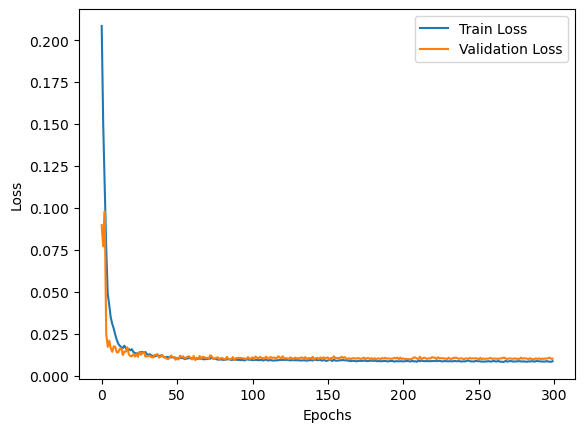

In [19]:
num_e = 300

plot_learning_curve(num_e, train_losses, val_losses)

#### Load model and predict spectra

In [20]:
# Load the saved model
num_tasks = 200

model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
mode = model.to(device)
model.load_state_dict(torch.load("ML_models/model_gnn_new.pt"))

<All keys matched successfully>

#### Plot predicted spectra

In [21]:
# Create empty dictionary to contain spectra
predict = {}
true = {}

# Loop over all molecules in test dateset and assign to dictionary index
for index in range(len(test_dataset)):
    predict[index], true[index] = pred_spec(model, index, test_dataset)

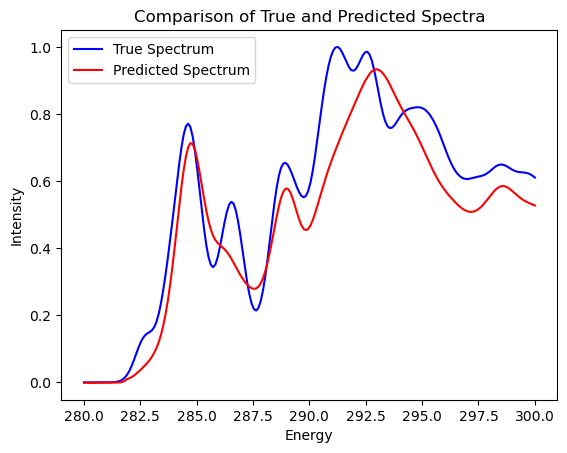

In [26]:
save_var = 0

plot_spectra(predict[2], true[2], save_var)

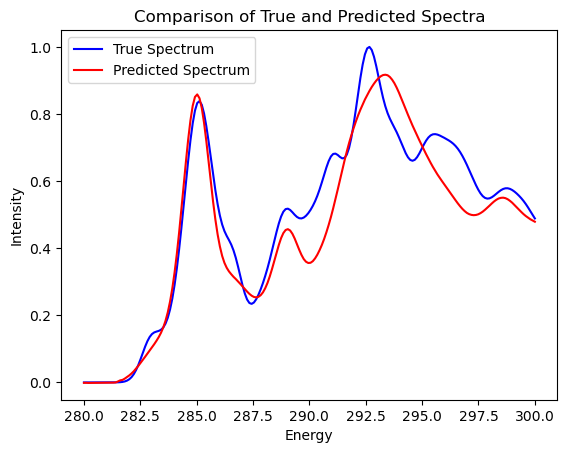

In [23]:
plot_spectra(predict[5], true[5], save_var)

In [ ]:
model_dict = [predict, true]

#### Save spectra

In [ ]:
with open("spectra_results/spectra_ml_21.pkl", "wb") as file:
    pkl.dump(model_dict, file)